In [2]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
folder = r"./stability_output_lowclash" #path to folder with all the output to analyze

def find_energy(line):
    parts = line.split()  # Split the line by whitespace
    pdb_name = os.path.basename(parts[0])  # Extract the PDB name from the first part
    energy = float(parts[1])  # Extract the first number after the PDB name
    return pdb_name, energy

namelist=[] #names for all designs
energylist=[] #All energies with indices corresponding to the namelist
names_and_scores=[] #Will be a list of dictionaries with names and corresponding scores
for filename in os.listdir(folder):
    if filename.endswith('.fxout'):
        filepath = os.path.join(folder, filename)
        with open(filepath, 'r') as file:
            for line in file:
                pdb_name, energy = find_energy(line)
                name = pdb_name[pdb_name.find('_')+1:filename.find('.')-5] #clean name
                namelist.append(name)
                energylist.append(energy)
                d={'%s'%name: energy}
                names_and_scores.append(d)
                break
#Sort proteins by score from lowest to highest:
names_and_scores = sorted(names_and_scores, key=lambda x: float(list(x.values())[0]))

print(names_and_scores)

[{'B12': -66.9836}, {'B32': -62.9062}, {'B20': -48.3235}, {'B30': -40.8815}, {'B48': -30.5806}, {'B5': -30.534}, {'B15': -29.5256}, {'B8': -23.7033}, {'B49': -19.1972}, {'B38': -13.4235}, {'B33': -13.2383}, {'B28': -8.38797}, {'B18': -8.0993}, {'B2': -4.52}, {'B39': -4.43095}, {'B46': -2.58772}, {'B21': -2.07462}, {'B22': 0.768835}, {'B44': 3.98539}, {'B13': 9.26269}, {'B47': 10.0594}, {'B7': 10.7222}, {'B35': 13.9847}, {'B36': 17.2687}, {'B45': 18.1536}, {'B31': 18.741}, {'B9': 18.8549}, {'B27': 24.5651}, {'B25': 25.1005}, {'B11': 27.3187}, {'B17': 29.3809}, {'B43': 32.1952}, {'B50': 33.0216}, {'B16': 46.2504}, {'B41': 48.5249}, {'B40': 57.8337}, {'C3': 58.7227}, {'B26': 61.1957}, {'B29': 61.6001}, {'B34': 68.316}, {'B10': 68.429}, {'A3': 69.0683}, {'B3': 69.3294}, {'C1': 71.4731}, {'B1': 74.8387}, {'B6': 79.2962}, {'B4': 81.5837}, {'B19': 100.026}, {'B14': 104.224}, {'A2': 116.376}, {'C4': 129.82}, {'C5': 131.867}, {'B37': 139.887}, {'B42': 147.347}, {'C2': 160.561}, {'A1': 171.152}]

The following codeblocks will compare the ranking to the RMSD values of the catalytic site

In [4]:
import matplotlib.pyplot as plt
import MDAnalysis as mda
from MDAnalysis.analysis import rms
import pickle
import warnings
warnings.filterwarnings('ignore')#suppress some MDAnalysis warnings about PSF files

In [5]:
def find_activesite(c): #c is in the format c=str('74-74/A90-100/94-94/A160-170/46-46/A185-195/16-16/A205-215/16-16/A237-247/25-25')
    cs = c.split('/')
    inserts = []
    sites = []
    for i in cs:
        css = i.split('-')
        if css[0][0] == 'A':
            sites.append([int(css[0][1:]), int(css[1])])
        else:
            inserts.append(int(css[0]))
    #as1 is active site 1, same for as2 and as3
    as1=1+inserts[0] + (sites[0][1]-sites[0][0]+1) + inserts[1] + 165-sites[1][0]
    
    as2=1+inserts[0] + (sites[0][1]-sites[0][0]+1) + inserts[1] + (sites[1][1]-sites[1][0]+1) + inserts[2] + \
    (sites[2][1]-sites[2][0]+1) + inserts[3] + 210-sites[3][0]
    
    as3=1+inserts[0] + (sites[0][1]-sites[0][0]+1) + inserts[1] + (sites[1][1]-sites[1][0]+1) + inserts[2] + \
    (sites[2][1]-sites[2][0]+1) + inserts[3] + (sites[3][1]-sites[3][0]+1) + inserts[4] + 242-sites[4][0]
    cat_triad=[as1, as2, as3]
    return(cat_triad)

def find_bindingsite(c): #c is in the format c=str('74-74/A90-100/94-94/A160-170/46-46/A185-195/16-16/A205-215/16-16/A237-247/25-25')
    cs = c.split('/')
    inserts = []
    sites = []
    for i in cs:
        css = i.split('-')
        if css[0][0] == 'A':
            sites.append([int(css[0][1:]), int(css[1])])
        else:
            inserts.append(int(css[0]))
   #bs1 is bindingsite 1, same for bs2 and bs3
    bs1=1+inserts[0] + 95-sites[0][0]
    bs2=1+inserts[0] + (sites[0][1]-sites[0][0]+1) + inserts[1] + 166-sites[1][0] 
    bs3=1+inserts[0] + (sites[0][1]-sites[0][0]+1) + inserts[1] + (sites[1][1]-sites[1][0]+1) + inserts[2] + \
    + 190-sites[2][0]
    bindingsite=[bs1, bs2, bs3]
    return(bindingsite)

    
def rmsd(design_dir, activeres): #takes in the directory of the pdb file and a list of the catalytic triad and returns rmsd for catalytic triad
    s=activeres[0]
    d=activeres[1]
    h=activeres[2]
    u = mda.Universe(r"%s" %design_dir)  
    ref = mda.Universe(r"C:\Users\Bruker\OneDrive - NTNU\femtis\Prosjektoppgave\6tht_mhet (3).pdb")
    return rms.rmsd(u.select_atoms('resid %s or resid %s or resid %s' %(s,d,h)).positions,  # coordinates to align
             ref.select_atoms('resid 165 or resid 210 or resid 242').positions,  # reference coordinates
             center=True,  # subtract the center of geometry
             superposition=True)  # superimpose coordinates

def rmsd_bindingsite(design_dir, bindingres): #takes in the directory of the pdb file and a list of three binding residues and returns rmsd for binding sites
    s=bindingres[0]
    d=bindingres[1]
    h=bindingres[2]
    u = mda.Universe(r"%s" %design_dir)  
    ref = mda.Universe(r"C:\Users\Bruker\OneDrive - NTNU\femtis\Prosjektoppgave\6tht_mhet (3).pdb") 
    return rms.rmsd(u.select_atoms('resid %s or resid %s or resid %s' %(s,d,h)).positions,  # coordinates to align
             ref.select_atoms('resid 95 or resid 166 or resid 190').positions,  # reference coordinates
             center=True,  # subtract the center of geometry
             superposition=True)  # superimpose coordinates

#Find rmsd of all pdb files and sort them from low to high:
def find_rmsd(dirlist, activeres, names, catalytic=False, binding=False): #Specify either catalytic OR binding to be True to find catalytic/binding rmsd
    results=[]
    for i in range(len(dirlist)):
        if catalytic:
            r=rmsd(dirlist[i], activeres[i])
        if binding:
            r=rmsd_bindingsite(dirlist[i], activeres[i])
        result={'%s'%names[i]: r}
        results.append(result)
        sorted_results = sorted(results, key=lambda x: float(list(x.values())[0]))
    return sorted_results #sorted_results is a list of dictionaries with name as key and rmsd as value

In [6]:
path = r"./RFdiffusion_output" #Contains all the output folders from RFdiffusion
dir_list = os.listdir(path)

dir1=[] #paths to trb files will be loaded into this list
dir2=[] #paths to pdb files will be loaded into this list
namelist=[] #names for all designs
for folder in dir_list:
    newpath=path+'/'+folder+'/outputs/'
    dir_list2=os.listdir(newpath)
    name=dir_list2[0]
    namelist.append(name)
    newpath2=newpath+name+'/'+'best.pdb'
    dir2.append(newpath2)
    a=os.listdir('%s' % newpath)
    for file in a:
        if '.trb' in file:
            dir1.append('%s'% newpath + '%s' %file)

#clean the names in the namelist
namelist = [name.split('_')[0] for name in namelist]

#open string of residues from .trb files and find active sites:
con=[]
activesites=[]
for d in dir1:
    with open('%s' %d, 'rb') as f:
        data=pickle.load(f)  
        c=str(data['config']['contigmap']['contigs']).replace("['","").replace("']","")
        con.append(c) 
    activesites.append(find_activesite(c)) 

#same for binding sites:
bindingsites=[]
for d in dir1:
    with open('%s' %d, 'rb') as f:
        data=pickle.load(f)  
        c=str(data['config']['contigmap']['contigs']).replace("['","").replace("']","") 
    bindingsites.append(find_bindingsite(c))


#Write sorted rmsd to file:
cat_rmsd=find_rmsd(dir2, activesites, namelist, catalytic=True) #catalytic triad
binding_rmsd=find_rmsd(dir2, bindingsites, namelist, binding=True) #binding sites
file = open("./rmsd_catalytic.txt", 'w')
file.write(str(cat_rmsd))
file = open("./rmsd_binding.txt", 'w')
file.write(str(binding_rmsd))
file.close()

print('Cat rmsd: %s' %cat_rmsd)
print('Binding rmsd: %s' %binding_rmsd)
print('FoldX stability: %s' %names_and_scores)

Cat rmsd: [{'B9': 1.804325779036131}, {'B3': 1.8057676546762975}, {'B2': 1.8064938863543893}, {'B27': 1.8068611392238116}, {'B8': 1.8069738229685386}, {'B38': 1.8071474799270142}, {'B48': 1.8073244397088137}, {'B35': 1.8083187738106086}, {'B6': 1.8087978518552723}, {'B13': 1.8099303384462917}, {'B47': 1.8100403261455442}, {'B33': 1.8105474008988862}, {'B41': 1.8109033353669535}, {'B29': 1.8110657742081324}, {'B10': 1.811127878543341}, {'B45': 1.8114364139441546}, {'B1': 1.8114715038865234}, {'B40': 1.811844467399151}, {'B21': 1.8123965950516863}, {'B49': 1.813085604467712}, {'B34': 1.813182874657993}, {'B15': 1.81405104404181}, {'B26': 1.8148876581795996}, {'B44': 1.8152321497060475}, {'B37': 1.815880000257533}, {'B25': 1.8162780300651529}, {'B50': 1.8164116721065842}, {'B30': 1.8166429425837338}, {'B14': 1.818123083613085}, {'B31': 1.8191832675954003}, {'B20': 1.82069101683615}, {'B39': 1.8216286277147946}, {'B19': 1.823282082591733}, {'B7': 1.823495251977473}, {'B42': 1.8237075686724

In [7]:
#Find proteins under given rmsd cutoffs
rmsd_cutoff=2
proteins_under_cutoff = []

for r1 in cat_rmsd:
    for r2 in binding_rmsd:
        for name1, rmsd1 in r1.items():
            for name2, rmsd2 in r2.items():
                if name1 == name2 and rmsd1 < rmsd_cutoff and rmsd2 < rmsd_cutoff:
                    proteins_under_cutoff.append(name1)

print(proteins_under_cutoff)

['B9', 'B38', 'B41', 'B15', 'B37', 'B25', 'B50', 'B19', 'B42', 'B17', 'B22', 'B18']


In [14]:
#Compare proteins that have RMSD<2Å with the FoldX stability
stability_index = []

for protein in proteins_under_cutoff:
    for index, score in enumerate(names_and_scores):
        if protein in score:
            stability_index.append({protein: index})
            break

print(stability_index)

[{'B9': 26}, {'B38': 9}, {'B41': 34}, {'B15': 6}, {'B37': 52}, {'B25': 28}, {'B50': 32}, {'B19': 47}, {'B42': 53}, {'B17': 30}, {'B22': 17}, {'B18': 12}]


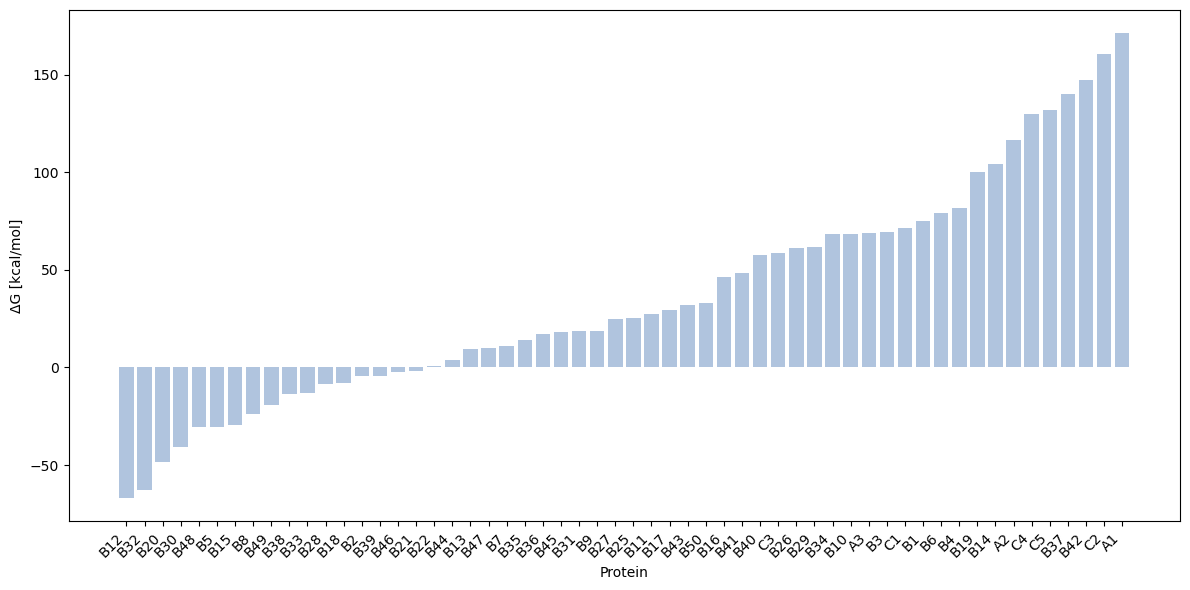

In [10]:
data=names_and_scores
keys = [list(d.keys())[0] for d in data]
values = [list(d.values())[0] for d in data]

plt.figure(figsize=(12, 6))
plt.bar(keys, values, color='lightsteelblue')
plt.xlabel('Protein')
plt.ylabel('ΔG [kcal/mol]')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()

#plt.savefig("FoldX_stability_minimized.png", bbox_inches="tight",
            #pad_inches=0.3, dpi=300)
plt.show()


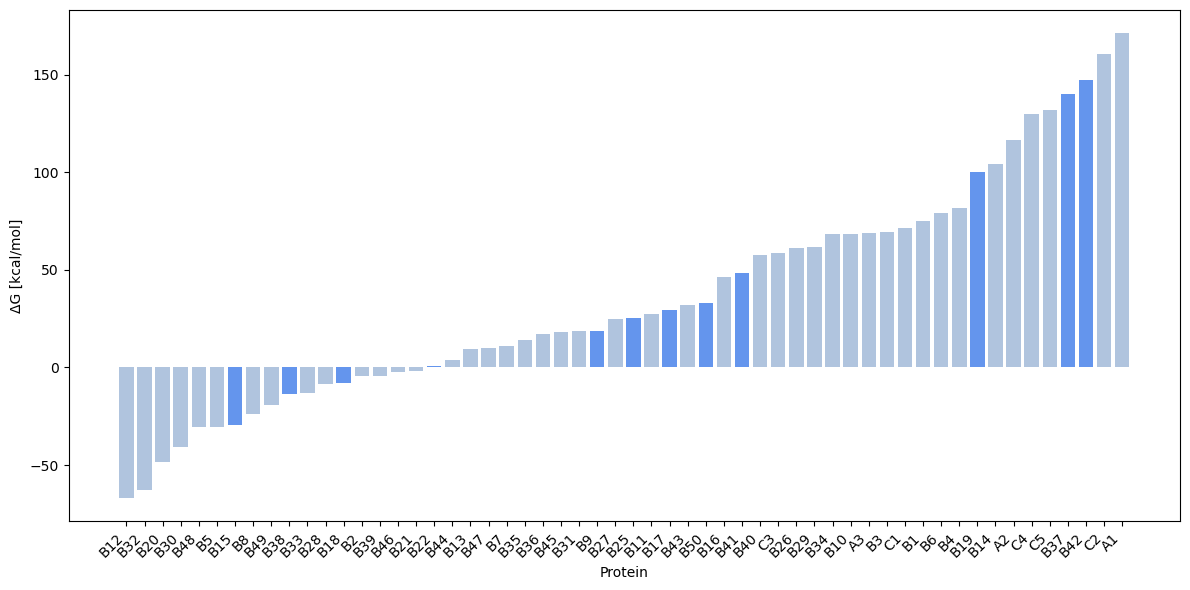

In [12]:
data=names_and_scores
keys = [list(d.keys())[0] for d in data]
values = [list(d.values())[0] for d in data]


c=['cornflowerblue' if key in proteins_under_cutoff else 'lightsteelblue' for key in keys]

plt.figure(figsize=(12, 6))
plt.bar(keys, values, color=c)
plt.xlabel('Protein')
plt.ylabel('ΔG [kcal/mol]')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.savefig("FoldX_stability_minimized_cutoff2Å.png", bbox_inches="tight",
            pad_inches=0.3, dpi=300)
plt.show()
